# fMRI-02 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

Today's demonstration will be in two parts. In the first section, we will show you how to generate the predicted BOLD signal for analysis of a block design experiment. In the second section, we will demonstrate from first principles why the optimal length of a block in a block design task is approximately 16 seconds.

## Part 1: Generating the predicted BOLD signal

In this first section, we will generate the predicted BOLD signal for a simple block design experiment. In fact, it was one of the experiments collected last year as part of NEU502b. In this experiment, we presented to participants alternating blocks of a [visual checkerboard](https://www.youtube.com/watch?v=xEd1h_lz4rA) (warning: flashing lights) and an empty black background, each presented for 20 seconds a time. 

A participant views six total blocks (i.e. 6 checkerboard presentations, 6 background presentations). Also, the paradigm begin with 10s of blank background presentation. Images were collected at a rate of 1 acquisition per second (TR=1). As we demonstrated last Wednesday, this paradigm robustly excited early visual cortex.

To generate for this experiment its expected neural activity, and corresponding BOLD signal, we will perform the following:
1. Define the (super-sampled) experiment times.
2. Generate the neural "boxcars".
3. Define the hemodynamic response function (HRF).
4. Convolve the boxcar timeseries with the HRF.
5. Downsample expected BOLD timeseries.

### [1] Define (super-sampled) times
Here we define the timing of the experiment. Importantly we first define the experiment in a "super-sampled" space, or we act like we have acquired far more data points than we actually have. We do this for several reasons. First, it functions to reduce the noisiness of our convolved regressors (more on that in a minute). Second, it allows us to model events that occur between TRs.

In [2]:
## Define experiment metadata.
n_times = 10 + 6 * 20 + 6 * 20
sfreq = 0.1

## Define (super-sampled) times.
sst = np.arange(0, n_times, sfreq)

### [2] Generate boxcars
Here we define a "boxcar" timeseries. In this step we make a binary timeseries (comprised of 0s and 1s), where 0s represent neuronal silence and 1s represent neuronal activity. Essentially, we initialize a timeseries that is as long as the number of times defined above, where the value of the timeseries is 1 if we expect the neurons to be active in that minute, and 0 otherwise. The term boxcar comes from the boxy pattern that results from this process.

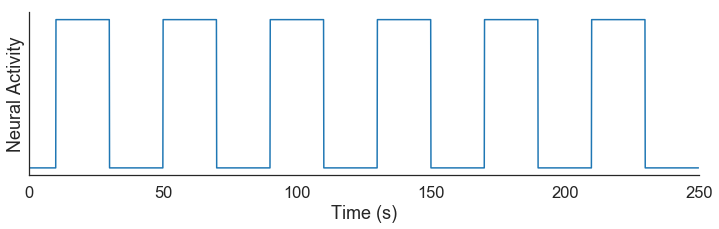

In [3]:
## Define experiment events.
events = [(10,30),(50,70),(90,110),(130,150),(170,190),(210,230)]

## Generate boxcars.
boxcars = np.zeros_like(sst)
for onset, offset in events:
    boxcars[np.logical_and(sst >= onset, sst < offset)] = 1
    
## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, boxcars);
ax.set(xlim=(0,n_times), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [3] Define the HRF
In this step, we define the expected shape of the HRF. Following convention, we will use the **SPM HRF**. 

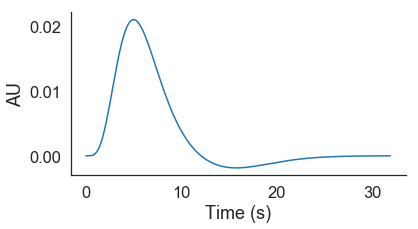

In [4]:
from fmritools.hrf import spm_hrf

## Define HRF.
hrf = spm_hrf(sfreq)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(sst[:hrf.size], hrf);
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()

### [4] Convolution
Convolution describes a particular mathematical operation where we use two functions to produce a third function that expresses how the shape of one is modified by the other. In this case, we convolve the boxcars with the HRF to model how we expect the BOLD signal to change in response to the neural activity

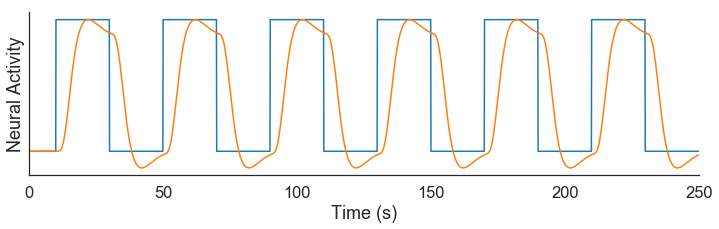

In [5]:
## Convolve boxcars + HRF.
bold = np.convolve(boxcars, hrf)[:sst.size]

## Normalize regressor.
bold /= bold.max()

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, boxcars);
ax.plot(sst, bold);
ax.set(xlim=(0,n_times), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [5] Downsampling
In this fifth and final step, we reduce the convolved timeseries to only those observations that we actually acquired.

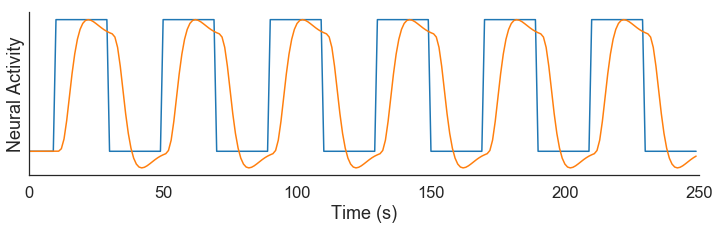

In [6]:
## Define observation times.
tr = 1
times = np.arange(n_times) * tr

## Define downsampling indices.
ix = np.in1d(sst, times)

## Downsampling.
boxcars = boxcars[ix]
bold = bold[ix]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, boxcars);
ax.plot(times, bold);
ax.set(xlim=(0,n_times), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

## Part 1.5: Simple Regression
Next, let's use the predicted BOLD timeseries we just made and use it perform simple linear regression.

### [1] Load and visualize data

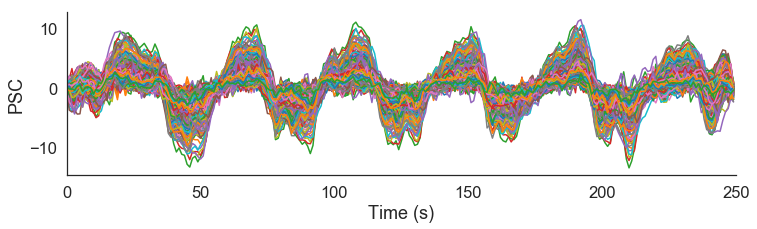

In [7]:
## Load and extract data.
npz = np.load('fmri-02-regression.npz')
times = npz['times']
y = npz['y']

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y);
ax.set(xlim=(0,n_times), xlabel='Time (s)', ylabel='PSC')
sns.despine()

### [2] Construct design matrix
The design matrix is collection of timeseries we will predicted the observed data here. Here we use the timeseries we made and an intercept, i.e. a column of 1s.

In [8]:
X = np.column_stack([np.ones_like(bold), bold])

### [3] Regression

Mean b1 = 3.056


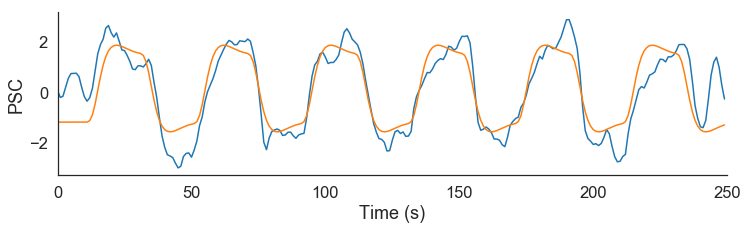

In [9]:
## Perform regression.
b, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
print('Mean b1 = %0.3f' %b[1].mean())

## Posterior predictive check.
yhat = X @ b

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y.mean(axis=1));
ax.plot(times, yhat.mean(axis=1));
ax.set(xlim=(0,n_times), xlabel='Time (s)', ylabel='PSC')
sns.despine()

## Part 2: fMRI detection power
In the second part of this demonstration, we will explore the measure of fMRI detection power. We will define detection power as the ability to detect nonzero changes in functional activity. Detection power lets us know how well suited our experiment design is for measuring differences in the BOLD signal from baseline or between two conditions.

### [1] Load and visualize example designs

To get started, let's look at four example block design experiments.

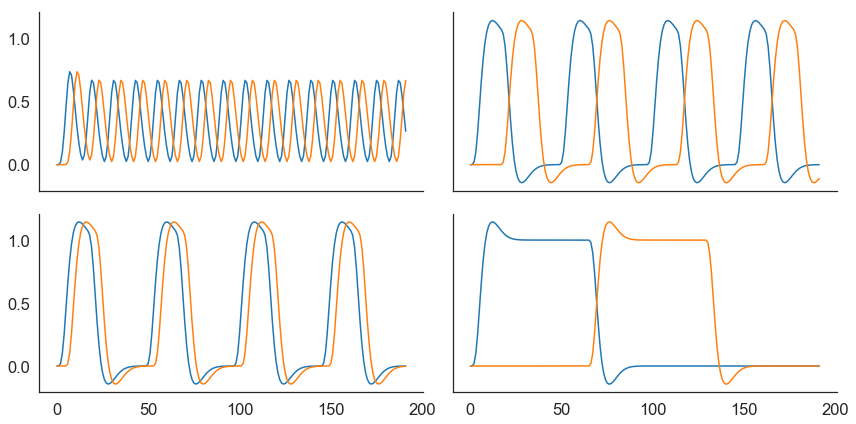

In [10]:
## Load experiment designs.
npz = np.load('fmri-02-power.npz')
X1 = npz['X1']; X2 = npz['X2']; X3 = npz['X3']; X4 = npz['X4']
times = npz['times']

## Plot designs.
fig, axes = plt.subplots(2,2,figsize=(12,6),sharex=True,sharey=True)
for ax, X in zip(axes.flatten(), [X1, X2, X3, X4]): ax.plot(times, X)
sns.despine()
plt.tight_layout()

### [2] Defining detection power

[Liu & Frank (2004)](https://www.sciencedirect.com/science/article/pii/S1053811903005779) provided a formal definition of detection power:

$$ R_{tot} = \frac{1}{ \frac{1}{N} \sum_{i \leq j} \frac{1}{R_{ij}} } $$

Put another way, the total detection power of our experimental design, $R_{tot}$, is the inverse of the average detection power of the contrasts of interest, $R_{ij}$. Here, a contrast refers to a particular statistical difference we might calculate. For example, we might ask whether a particular condition shows a BOLD signal change different than zero; alternately, we might ask whether there is a difference in BOLD signal change between two conditions.

We define the detection power of a particular contrast as:

$$ R_{ij} = \frac{ \left[ D_{ij}(X^T X)^{-1}D_{ij} \right]^{-1} }{h^Th} $$

Now, this may look daunting but it is actually fairly simple:

- $X$ is the design matrix, i.e. the matrix of regressors from above.
- $h$ is the assumed hemodynamic response function.
- $D$ is a contrast vector, corresponding to the main effects, $[1,0], [0,1]$ and pairwise contrasts, $[1,-1]$. 

Of these values, the most important is $X^TX$, or the [Fisher information matrix](https://en.wikipedia.org/wiki/Fisher_information), which has some important properties that we will not go into here. For the present purposes, the important thing to know to know is that an optimal design will have large values along the diagonal of this matrix, and small values in its off-diagonals. Why is this so?

Consider again the design matrix, $X$. It is an $[N,K]$ matrix where $N$ is the number of time points and $K$ is the number of conditions. Therefore, $X^TX$ simply returns a $[K,K]$ matrix. The diagonals of this matrix are the dot product of the regressors with themselves. As such, it is apparent when the diagonals of the Fisher information matrix are large: when the regressors themselves, on average, deviate from zero. When the estimated BOLD response differs greatly from zero, we should expect that nonzero changes in the observed BOLD signal will be easier to detect. Hence, a design matrix with larger diagonal elements in its corresponding Fisher information matrix is more optimal.

The converse is true for the off-diagonals. The off-diagonals of the Fisher information matrix are computed from the pairwise dot product of the columns of the design matrix. As such, the off-diagonals are large when, on average, the estimated BOLD signal for two conditions deviate from zero in the same direction at the same time. If we want to be able to resolve differences between conditions, then we want the estimated BOLD signal of two conditions to be orthogonal. Hence, a design matrix with smaller off-diagonal elements in its corresponding Fisher information matrix is more optimal.

The Fisher information matrices of our four designs are presented below.

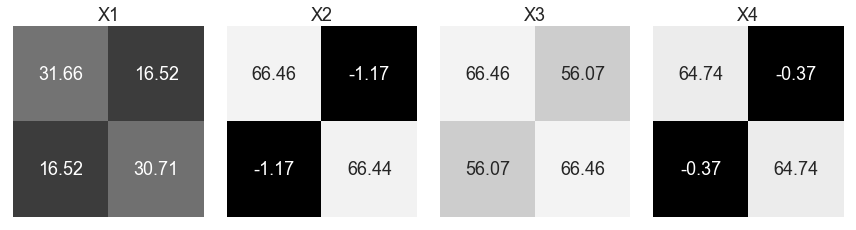

In [11]:
## Plot Fisher information.
fig, axes = plt.subplots(1,4,figsize=(12,4),sharex=True,sharey=True)

for i, (ax, X) in enumerate(zip(axes.flatten(), [X1, X2, X3, X4])): 
    sns.heatmap(X.T @ X, vmin=0, vmax=70, cmap='binary_r', square=True, cbar=False,
                annot=True, fmt='0.2f', annot_kws=dict(fontsize=18), ax=ax)
    ax.set(xticks=[], yticks=[], title='X%s' %(i+1))
plt.tight_layout()

### [3] Compute and plot detection power

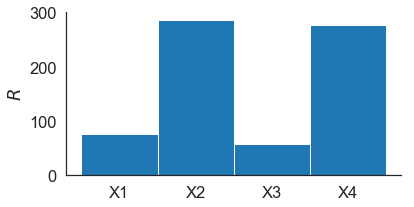

In [12]:
from fmritools.design import detection_power

## Initialize plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Iteratively compute and plot.
for i, X in enumerate([X1,X2,X3,X4]):
    R = detection_power(X, 1)
    ax.bar(i,R,1,color='#1f77b4')

## Add details to plot.
ax.set(xticks=range(4), xticklabels=['X1','X2','X3','X4'], ylim=(0,300),ylabel=r'$R$')
sns.despine()

### [4] Re-estimating detection power assuming drifts
Why does the 4th design have such high detection power despite the conventional wisdom? The answer has to do with artifactual noise observed in fMRI data. Unfortunately, fMRI data is often contaminated by low frequency drifts. By the same logic as above, a design is robust when it is nearly orthogonal to the nuisance terms. If the on-off cycle of stimuli blocks is too slow, then it may overlap with the low-frequency drifts (i.e. off-diagonal terms) thereby reducing overall detection power. We can simulate this effect by including Legendre polynomials (up to order 2) as nuisance regressors in the design matrix.

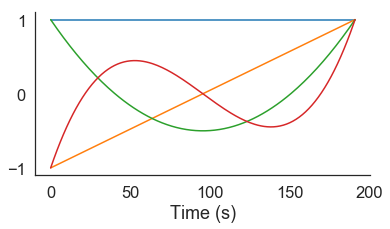

In [13]:
from fmritools import legendre

## Generate Legendre polynomials.
Z = legendre(times.size, order=3)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(times, Z);
ax.set(xlabel='Time (s)')
sns.despine()

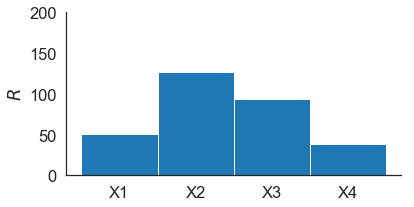

In [14]:
## Initialize plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Iteratively compute and plot.
for i, X in enumerate([X1,X2,X3,X4]):
    R = detection_power(np.column_stack([X,Z]), 1)
    ax.bar(i,R,1,color='#1f77b4')

## Add details to plot.
ax.set(xticks=range(4), xticklabels=['X1','X2','X3','X4'], ylim=(0,200),ylabel=r'$R$')
sns.despine()